# Beijing Air Quality Forecasting Starter Notebook

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [ ]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [ ]:
print("✅ Data Loaded")
print(train.head())

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [ ]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [ ]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [ ]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


In [ ]:
def create_sequences(data, target, window_size=24):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i+window_size].values)
        y.append(target.iloc[i+window_size])
    return np.array(X), np.array(y)

# Call function to get sequence data
X_train, y_train = create_sequences(
    train.drop(['pm2.5', 'No'], axis=1),
    train['pm2.5'],
    window_size=24
)

print(f"New X_train shape: {X_train.shape}")  # (samples, timesteps=24, features)
print(f"New y_train shape: {y_train.shape}")


New X_train shape: (30652, 24, 9)
New y_train shape: (30652,)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(train.drop(['pm2.5', 'No'], axis=1))
scaled_train = pd.DataFrame(scaled_features, index=train.index, columns=train.drop(['pm2.5','No'], axis=1).columns)

X_train, y_train = create_sequences(scaled_train, train['pm2.5'], window_size=24)

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [ ]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [ ]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

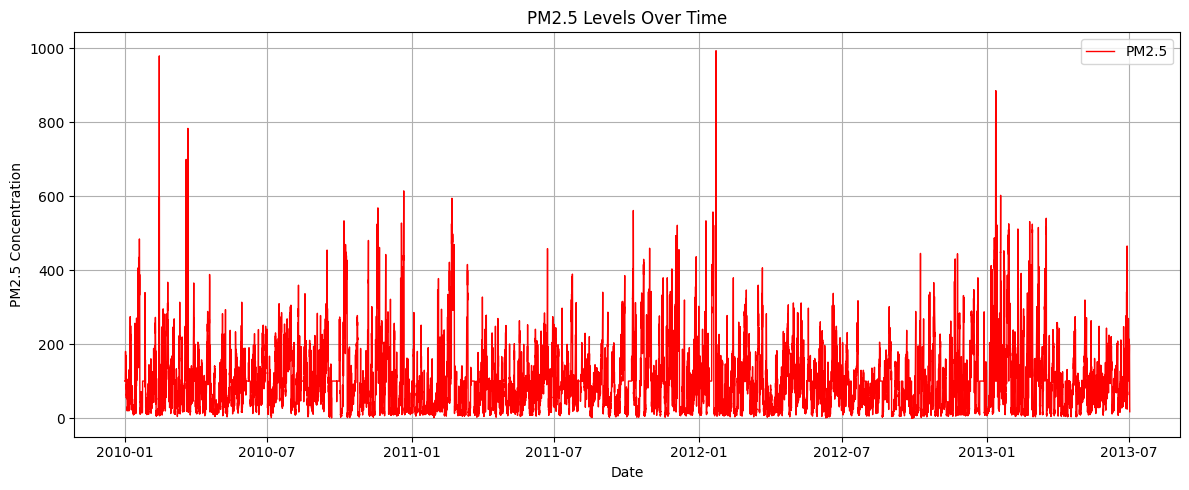

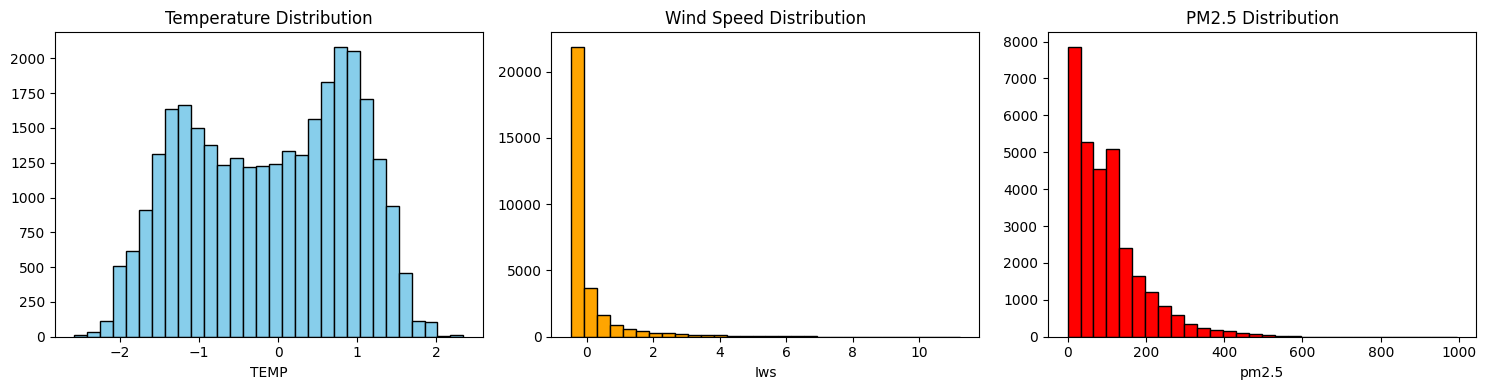

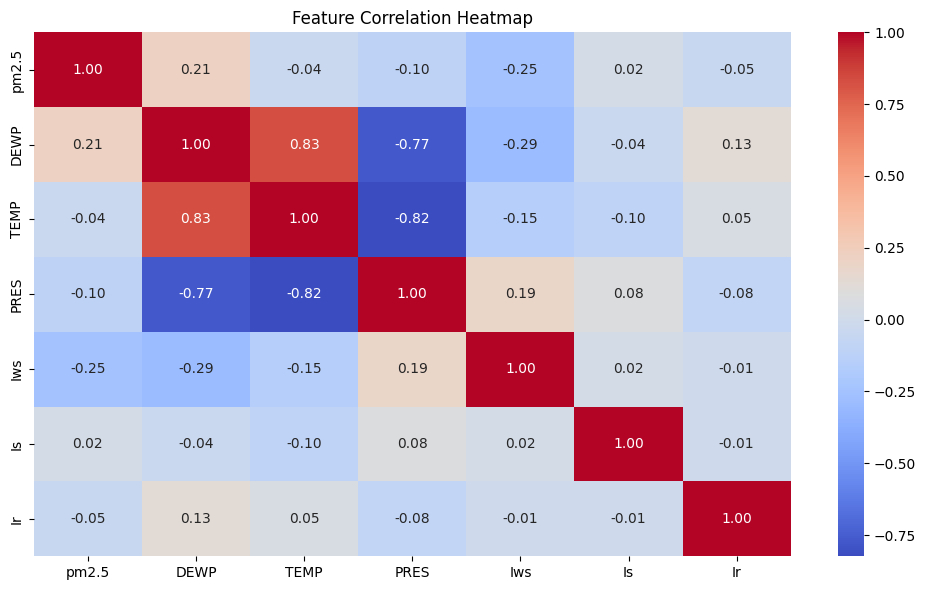

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

#  Line plot - PM2.5 trend over time
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['pm2.5'], label='PM2.5', color='red', linewidth=1)
plt.title("PM2.5 Levels Over Time")
plt.xlabel("Date")
plt.ylabel("PM2.5 Concentration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Histograms - Distribution of key features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(train['TEMP'].dropna(), bins=30, color='skyblue', edgecolor='black')
axes[0].set_title("Temperature Distribution")
axes[0].set_xlabel("TEMP")

axes[1].hist(train['Iws'].dropna(), bins=30, color='orange', edgecolor='black')
axes[1].set_title("Wind Speed Distribution")
axes[1].set_xlabel("Iws")

axes[2].hist(train['pm2.5'].dropna(), bins=30, color='red', edgecolor='black')
axes[2].set_title("PM2.5 Distribution")
axes[2].set_xlabel("pm2.5")

plt.tight_layout()
plt.show()

# Heatmap - Correlation between features
plt.figure(figsize=(10, 6))
corr_matrix = train[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [46]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional

# --- Experiment Parameters ---
units_1 = 128             # First LSTM layer units
units_2 = 64              # Second LSTM layer units
dropout_rate = 0.25       # Dropout to prevent overfitting
learning_rate = 0.0005    # Adam usually works well with smaller LR

optimizer_choice = Adam(learning_rate=learning_rate)

# --- Build Model ---
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Bidirectional(LSTM(units_1, activation='tanh', return_sequences=True)),
    Dropout(dropout_rate),
    LSTM(units_2, activation='tanh'),
    Dropout(dropout_rate),
    Dense(1)
])

# Compile Model
model.compile(
    optimizer=optimizer_choice,
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 1, 256)         │       141,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,553 (873.25 KB)

 Trainable params: 223,553 (873.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Callbacks ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# --- Train Model ---
history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/60
384/384 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 16018.3506 - rmse: 126.5483 - val_loss: 19495.6094 - val_rmse: 139.6267 - learning_rate: 5.0000e-04
Epoch 2/60
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 12935.8076 - rmse: 113.7063 - val_loss: 17558.7207 - val_rmse: 132.5093 - learning_rate: 5.0000e-04
Epoch 3/60
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 11493.1650 - rmse: 107.1847 - val_loss: 16188.5127 - val_rmse: 127.2341 - learning_rate: 5.0000e-04
Epoch 4/60
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 10272.4805 - rmse: 101.3080 - val_loss: 15031.8486 - val_rmse: 122.6044 - learning_rate: 5.0000e-04
Epoch 5/60
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 9606.1484 - rmse: 97.9803 - val_loss: 14037.5752 - val_rmse: 118.4803 - learning_rate: 5.0000e-04
Epoch 6/60
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 8729.9912 - rmse: 93.4225 - val_loss: 13165.0234 - val_rmse: 114.7389 - learning_rate: 5.0000e-04
Epoch 7/60
384/384 ━━━━━━━━━━━━━━━━━━

959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


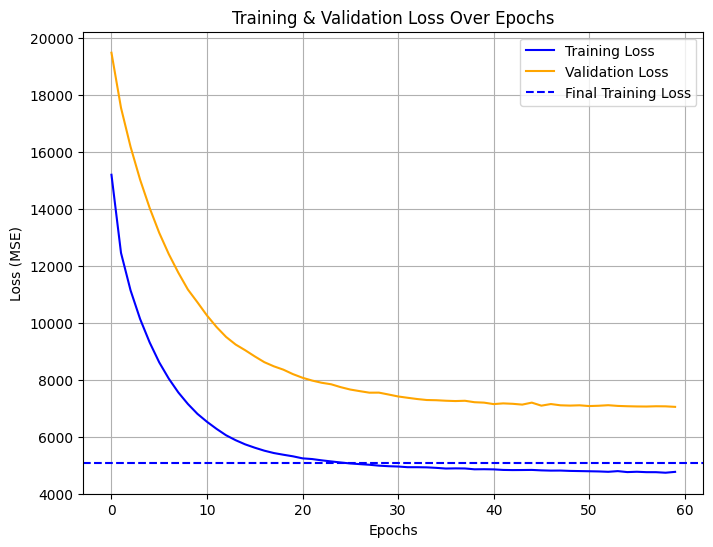

✅ Final Training Loss (MSE): 5089.63
✅ Final Training RMSE: 71.34 (same unit as PM2.5)


In [ ]:
# Calculate training predictions and loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)
train_rmse = np.sqrt(train_loss)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')

# Plot validation loss if available
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

# Horizontal line showing final training loss
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final Training Loss')

# Formatting
plt.title('Training & Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Print numerical results
print(f"✅ Final Training Loss (MSE): {train_loss:.2f}")
print(f"✅ Final Training RMSE: {train_rmse:.2f} (same unit as PM2.5)")


In [ ]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_fixed.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
